config : windows 10, python 3.9.3

In [6]:
!pip install opencv-python numpy mediapipe matplotlib

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/a6/08/583e1d8d589e80a702815f58daa317bd469a32c7dc339394e2a0dc14318b/opencv_python-4.8.0.74-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/86/c7/f92afdefa2bccdf0bc357321a931adafb1a999bc84f8877a6ed786a69ccc/numpy-1.25.1-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for mediapipe from https://files.pythonhosted.org/packages/2f/8a/f5f724f97a2cfc7e8403d7de45643f32e08bf91778c94a1f793bb09155fb/mediapipe-0.10.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c9/46/6cbaf20f5bd0e7c1d204b45b853c2cd317b303fada90245f2825ecca47de/matplotlib-3.7.2-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/126.5 kB ? eta -:--:--
     -------------------------------------- 126.5/126.5 kB 7.3 MB/s eta 0:00:00


In [7]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

init

In [9]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,min_detection_confidence=0.3,model_complexity=2)
mp_drawing = mp.solutions.drawing_utils

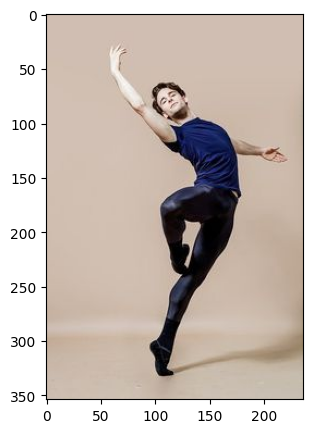

In [26]:
img = cv2.imread('C:/Users/cosmo/Projects/YogaPoseHelper/media/gay_man.jpg')
plt.figure(figsize=[5,5])
plt.imshow(img[:,:,::-1])
plt.show()

Pose detection

In [45]:
results = pose.process(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
)  # converting image to rgb format
landmarks = []
if results.pose_landmarks:
    for i in range(32):
        norm_landmark = results.pose_landmarks.landmark[mp_pose.PoseLandmark(0).value]
        print(f"{mp_pose.PoseLandmark(i).name}:\n{norm_landmark}")
        landmarks.append(np.array([norm_landmark.x, norm_landmark.y, norm_landmark.z]))

NOSE:
x: 0.48231637477874756
y: 0.22658061981201172
z: -0.3600298762321472
visibility: 0.9999392032623291

LEFT_EYE_INNER:
x: 0.4812281131744385
y: 0.21460804343223572
z: -0.3042536675930023
visibility: 0.9999324083328247

LEFT_EYE:
x: 0.48993903398513794
y: 0.21128961443901062
z: -0.3048655390739441
visibility: 0.9999330043792725

LEFT_EYE_OUTER:
x: 0.49783262610435486
y: 0.20849977433681488
z: -0.3044549524784088
visibility: 0.9999486207962036

RIGHT_EYE_INNER:
x: 0.45902207493782043
y: 0.22475497424602509
z: -0.3219935894012451
visibility: 0.9999483823776245

RIGHT_EYE:
x: 0.4524313807487488
y: 0.22890053689479828
z: -0.32300102710723877
visibility: 0.9999586343765259

RIGHT_EYE_OUTER:
x: 0.4473980963230133
y: 0.2326754331588745
z: -0.3235831558704376
visibility: 0.9999502897262573

LEFT_EAR:
x: 0.5161305665969849
y: 0.2144564986228943
z: -0.06358041614294052
visibility: 0.9999582767486572

RIGHT_EAR:
x: 0.4530319571495056
y: 0.24319036304950714
z: -0.14670322835445404
visibility: 0

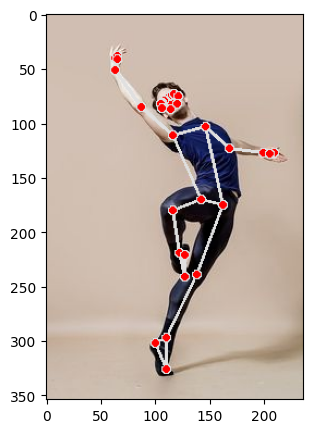

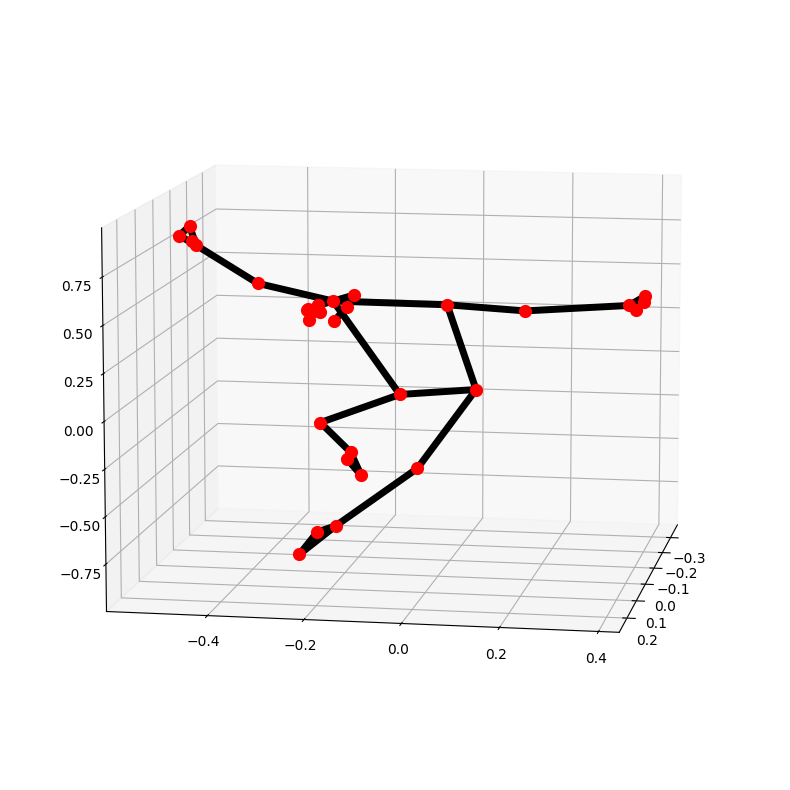

In [50]:
img_copy = img.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy,landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize=[5,5])
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

    # for 3d
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

Angle calculation

In [ ]:
def findAngle(p1:np.array, p2:np.array, p3:np.array):
    v1 = p1-p2
    v2 = p3-p2
    v1 = v1 / np.linalg.norm(v1); v2 = v2 / np.linalg.norm(v2)
    return math.acos(v1.x * v2.x + v1.y * v2.y + v1.z * v2.z)

gradient setup

In [150]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Function to generate gradient colors interpolating between two colors
def get_gradient_color(colors, n):
    start_color, end_color = colors
    r = np.linspace(start_color[0], end_color[0], n)
    g = np.linspace(start_color[1], end_color[1], n)
    b = np.linspace(start_color[2], end_color[2], n)
    return list(zip(r, g, b))

def draw_gradient_line_3d(
    ax_thing, start, end, left_intensity, right_intensity, num_points=100
):
    # Generate points along the line in 3D space
    x = np.linspace(start[0], end[0], num_points)
    y = np.linspace(start[1], end[1], num_points)
    z = np.linspace(start[2], end[2], num_points)
    
    # red to green to red interpolation based on red intensity on both ends 
    colors = get_gradient_color(
        [(left_intensity, 1 if left_intensity == 0 else 0, 0), (0, 1, 0)],
        num_points // 2,
    ) + get_gradient_color(
        [(0,1,0), (right_intensity, 1 if right_intensity == 0 else 0, 0)], num_points // 2
    )
    points = np.column_stack([x, y, z])

    line = Line3DCollection(list(zip(points[:-1], points[1:])), colors=colors, linewidths=3)

    # Add the line to the 3D plot
    ax_thing.add_collection3d(line)


Modified version of plotting function:

In [152]:
import dataclasses
from typing import List, Optional, Tuple
from mediapipe.framework.formats import landmark_pb2
import matplotlib as mpl

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)

@dataclasses.dataclass
class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 2
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 2

def _normalize_color(color):
  return tuple(v / 255. for v in color)


def custom_plot_landmarks(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=5),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=5),
                   elevation: int = 10,
                   azimuth: int = 10):
  """Plot the landmarks and the connections in matplotlib 3d.

  Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.

  Raises:
    ValueError: If any connection contains an invalid landmark index.
  """
  if not landmark_list:
    return
  plt.figure(figsize=(10, 10))
  ax = plt.axes(projection='3d')
  ax.view_init(elev=elevation, azim=azimuth)
  plotted_landmarks = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    ax.scatter3D(
        xs=[-landmark.z],
        ys=[landmark.x],
        zs=[-landmark.y],
        color=_normalize_color(landmark_drawing_spec.color[::-1]),
        linewidth=landmark_drawing_spec.thickness)
    plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
        landmark_pair = [
            plotted_landmarks[start_idx], plotted_landmarks[end_idx]
        ]


        draw_gradient_line_3d(ax_thing=ax,start=[_ for _ in landmark_pair[0]],end=[_ for _ in landmark_pair[1]],left_intensity=1,right_intensity=0,num_points=100)

  plt.show()

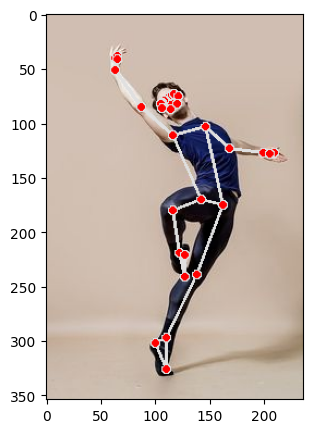

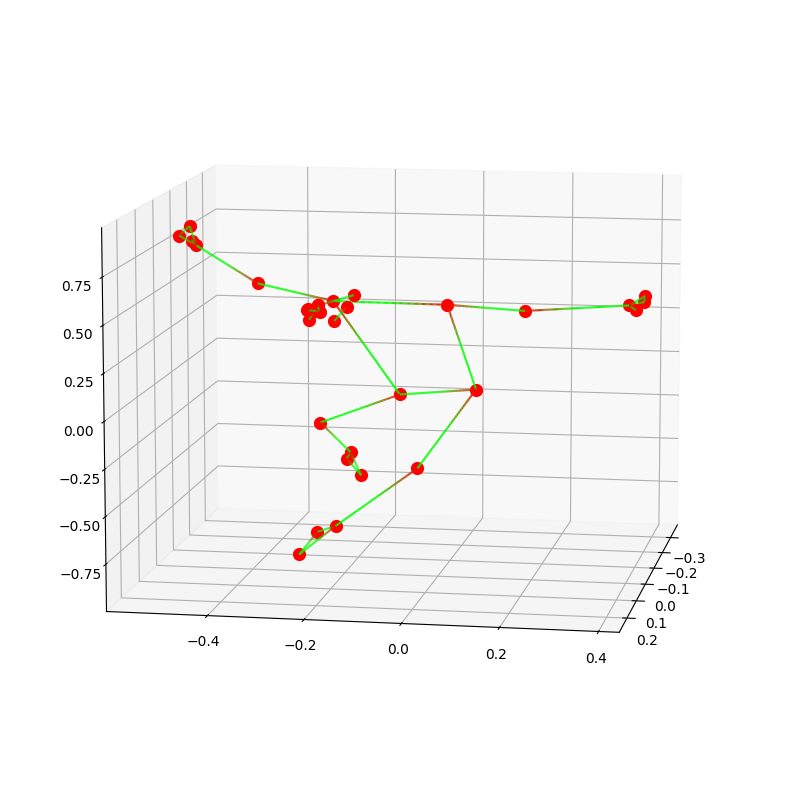

In [153]:
img_copy = img.copy()
if results.pose_landmarks:
    mp_drawing.draw_landmarks(image=img_copy,landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
    fig = plt.figure(figsize=[5,5])
    plt.imshow(img_copy[:,:,::-1])
    plt.show()

    # for 3d
    custom_plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)